In [1]:
# default_exp analyses

# The Spacing Effect
> "The beneficial mnemonic effects of spaced over massed learning is one of the most widely documented and well studied memory phenomena. Although it is seen in a wide range of tasks, the spacing effect is particularly strong in free recall, where the probability of recalling a repeated word often increases monotonically to spacings of 20 or more items (Cepeda, Pashler, Vul, Wixted, & Rohrer, 2006; Delaney, Verkoeijen, & Spirgel, 2010; Donovan & Radosevich, 1999; Madigan, 1969; Melton, 1970)." - Lohnas & Kahana, 2014

## Function

In [2]:
# export

from numba import njit, prange
import numpy as np

@njit(nogil=True, parallel=True)
def recall_probability_by_lag(study_positions_in_recall_order, presentations, max_lag=8):

    total_presented, total_retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)

    for trial_index in prange(len(presentations)):

        # nested accumulation to ensure parallelization doesn't cause problems
        presented, retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)
            
        # extract sequence of presentations
        presentation = presentations[trial_index]

        # extract sequence of responses
        responses = study_positions_in_recall_order[trial_index]
        responses = responses[responses > 0]-1

        # for each studied_item in presentation, identify its presentation positions
        for studied_item in np.unique(presentation):

            # identify occurrences of item index in presentation vector
            item_occurrences = np.where(presentation == studied_item)[0]

            # convert to incremental distances
            lags = item_occurrences[1:] - item_occurrences[:-1]
            
            # aggregate to select bin for accumulation
            index = 0 if lags.size == 0 else np.int64(np.mean(lags))

            # accumulate
            presented[index] += 1
            retrieved[index] += item_occurrences[0] in responses

        total_presented += presented
        total_retrieved += retrieved

    return total_retrieved/total_presented

## Howard & Kahana (2005) Dataset
> Kahana, M. J., & Howard, M. W. (2005). Spacing and lag effects in free recall of pure lists. Psychonomic Bulletin & Review, 12(1), 159-164.

In [3]:
from repetition_cmr.datasets import prepare_howakaha05_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_howakaha05_data(
    '../../data/HowaKaha05.dat')

for condition in [0, 2, 1]:
    print(recall_probability_by_lag(trials[list_types==condition], presentations[list_types==condition], max_lag=20))
    print()

[       nan 0.31747475        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]

[       nan        nan        nan 0.34175153 0.33896104 0.32182864
 0.35664336        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]

[       nan        nan        nan        nan        nan        nan
 0.33333333 0.37306202 0.34705882 0.37369792 0.34766119 0.38208617
 0.39018952 0.35162374 0.36267606 0.42324561 0.35549133 0.34013605
 0.38421053 0.35652174 0.45833333        nan]



## Lohnas & Kahana (2014) Dataset
> Siegel, L. L., & Kahana, M. J. (2014). A retrieved context account of spacing and repetition effects in free recall. Journal of Experimental Psychology: Learning, Memory, and Cognition, 40(3), 755.

In [4]:
from repetition_cmr.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

for condition in [1, 2, 3, 4]:
    result = recall_probability_by_lag(trials[list_types==condition], presentations[list_types==condition], max_lag=8)

    binned = np.zeros(5)
    binned[0] = result[0]
    binned[1] = result[1]
    binned[2] = (result[2] + result[3])/2
    binned[3] = (result[4] + result[5] + result[6])/3
    binned[4] = (result[7] + result[8] + result[9])/3
    print(binned)
    print()

%timeit recall_probability_by_lag(trials[list_types==condition], presentations[list_types==condition], max_lag=8)

[0.35446429        nan        nan        nan        nan]

[       nan 0.59738095        nan        nan        nan]

[       nan        nan 0.62086485 0.62818187 0.64590778]

[0.37278912 0.43928571 0.47678571 0.55714286 0.57857143]

7.04 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Plotting
We'll perform the analysis on each subject's data separately so we can compute error bars, and aggregate the results into a pandas dataframe.

In [5]:
# export

import pandas as pd

def df_recall_probability_by_lag(trials, presentations, subject_count, trial_count, max_lag=8):

    lags = ['N/A', '0', '1-2', '3-5', '6-8']
    result = {'subject': [], 'lag': [], 'prob': []}
    
    for subject in range(subject_count):

        subject_result = recall_probability_by_lag(
            trials[subject*trial_count:(subject+1)*trial_count], presentations[subject*trial_count:(subject+1)*trial_count], max_lag)
        
        binned = np.zeros(5)
        binned[0] = subject_result[0]
        binned[1] = subject_result[1]
        binned[2] = (subject_result[2] + subject_result[3])/2
        binned[3] = (subject_result[4] + subject_result[5] + subject_result[6])/3
        binned[4] = (subject_result[7] + subject_result[8] + subject_result[9])/3

        result['subject'] += [subject+1]*len(lags)
        result['lag'] += lags
        result['prob'] += binned.tolist()
        
    return pd.DataFrame(result)

Text(0, 0.5, 'Recall Probability')

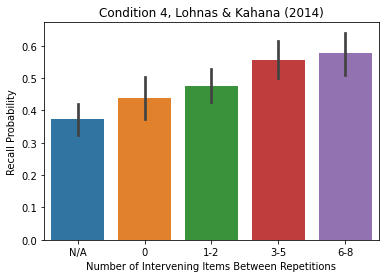

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

condition = 4
source = 'Lohnas & Kahana (2014)'

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = df_recall_probability_by_lag(
     trials[list_types>=4], presentations[list_types>=4],
    subject_count, trial_count, list_length)

sns.barplot(data=data, x='lag', y='prob')

plt.title('Condition {}, {}'.format(condition, source))
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')